# Computing Vertical Velocity with the QG omega equation

## General Info
#### Author

    Eugenio Cutolo, e.cutolo@imedea.uib-csic.es (IMEDEA)

#### Context

    Work done during my PhD at IMEDEA

#### Purpose

    Compute the vertical velocity from the Quasi-Geostrophic omega equation starting from the geostrophic velocities and density on a regular grid.


#### Todo and Remarks
    - Further libraries to solve PDE can be tested

    
## Terms of use and code sharing
This code is under Creative Commons Attribution-ShareAlike 4.0 International license (CC BY-SA 4.0).


You are free to:

  - Share — copy and redistribute the material in any medium or format
  - Adapt — remix, transform, and build upon the material
    for any purpose, even commercially.

Under the following terms:

 - Attribution — You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.

 - ShareAlike — If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original. 

In [1]:
import xarray as xr
import numpy as np

In [2]:
from findiff import FinDiff, operators, PDE, BoundaryConditions

### Load data and set parameters

In [3]:
dd = '/data/ecutolo/CALYPSO_postprocessing/'

In [4]:
fn = 'HYDR_DIVA3D_LX15_LY30_LZ4_eps0.15_ADV0_APG95.0_AX20.0_AY35.0_AE0.2.nc'

In [5]:
ds = xr.open_dataset(dd+fn)

In [6]:
# Horizontal grid spacing in meters
deltax = deltay = 2500 
# Considers only 1 vertical level every 20 to speed up the computation
zlevels = 20
deltaz = 10

In [7]:
# Coriolis parameter at mean latitude
omega_earth = 7.2921159e-5         # Earth's angular velocity
coriol_mean = 2 * omega_earth * np.sin(np.deg2rad(ds.lat.values.mean()))

In [8]:
ugeo = ds.ugeo.values[::zlevels]
vgeo = ds.vgeo.values[::zlevels]

In [9]:
err_mask = ds.density_err.mean('depth').transpose()<0.05

### Compute the Q vector

In [10]:
buyoancy = 9.8*ds.density.values.transpose()[::zlevels]/(1000+ds.density.values.mean())
N2 = (np.gradient(buyoancy,deltaz,axis=0))

Q = ( du/dx*db/dx + dv/dx*db/dy, du/dy*db/dx + dv/dy*db/dy)

In [11]:
QG = np.zeros((2,)+ugeo.shape)
QG[0] += np.gradient(ugeo,deltax,axis=2)*np.gradient(buyoancy,deltax,axis=2)
QG[0] += np.gradient(vgeo,deltax,axis=2)*np.gradient(buyoancy,deltay,axis=1)

QG[1] += np.gradient(ugeo,deltay,axis=1)*np.gradient(buyoancy,deltax,axis=2)
QG[1] += np.gradient(vgeo,deltax,axis=1)*np.gradient(buyoancy,deltax,axis=1)

divQG  = np.gradient(QG[0],deltax,axis=2) + np.gradient(QG[1],deltax,axis=1)

### Compute the two side of the equation

In [12]:
RHS = 2*divQG

In [13]:
LHS = operators.Coef(N2)*(FinDiff(2, deltax, 2) + FinDiff(1, deltay, 2))
LHS += coriol_mean*coriol_mean*FinDiff(0, deltaz, 2)

### Set the boundary conditions

In [14]:
bc = BoundaryConditions(RHS.shape)
bc[0,:] = 0  
bc[-1,:] = 0  
bc[:, 0] = 0   
bc[:, -1] = 0  
bc[:,:, 0] = 0   
bc[:,:, -1] = 0

### Solve the equation

In [15]:
pde = PDE(LHS, RHS, bc)

In [16]:
%time w = pde.solve()

CPU times: user 8.12 s, sys: 285 ms, total: 8.41 s
Wall time: 8.44 s


In [17]:
W = xr.DataArray(w[:,:,:], coords=[ds.depth[::zlevels],ds.yi,ds.xi],
                 dims=['depth','yi','xi'])

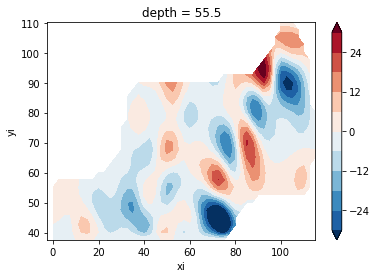

In [21]:
(W.isel(depth=5)*24*3600).where(err_mask).plot.contourf(levels=np.linspace(-30,30,11))

In [19]:
final_ds = W.to_dataset(name='wqg')
final_ds['lon'] = ds.lon
final_ds['lat'] = ds.lat

In [20]:
final_ds.to_netcdf(dd+fn.replace('HYDR_','WQG_FD_'))
fn.replace('HYDR_','WQG_FD_')

'WQG_FD_DIVA3D_LX15_LY30_LZ4_eps0.15_ADV0_APG95.0_AX20.0_AY35.0_AE0.2.nc'